In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%matplotlib widget

In [ ]:
def convert_datetime(time_pts: pd.core.series.Series) -> np.array:
    return np.array(time_pts, dtype='datetime64[m]')

def cap_temp_data(df: pd.DataFrame, temp_cap):
    df.iloc[:, 2:] = df.iloc[:, 2:].clip(upper=temp_cap)
    return df

In [ ]:
filepath = r"../Data/Dataset of weighing station temperature measurements.csv"

df = pd.read_csv(filepath, sep=';')

# Update le dataframe
capping_temp = 50
df = cap_temp_data(df, capping_temp)

,Time,Outdoor temperature [deg. C],Outdoor relative humidity [%],T[degC]-Low-S1,T[degC]-Low-S2,T[degC]-Low-S3,T[degC]-Low-S4,T[degC]-Low-S5,T[degC]-Low-S6,T[degC]-Low-S7,...,T[degC]-Top-S20,T[degC]-Top-S21,T[degC]-Top-S22,T[degC]-Top-S23,T[degC]-Top-S24,T[degC]-Top-S25,T[degC]-Top-S26,T[degC]-Top-S27,T[degC]-Top-S28,T[degC]-Top-S29
0,2023-12-21 12:10,-3.883333,42.333333,33.522705,31.560910,34.793104,30.900530,NaN,22.404998,33.093054,...,8.361203,14.383413,8.152400,11.794627,0.243417,-0.262979,0.135317,0.686731,-0.371935,0.519350
1,2023-12-21 12:12,-3.880000,42.400000,33.803224,31.345106,35.152043,30.010469,NaN,20.637749,32.470107,...,7.510757,13.676871,8.008640,11.373162,-0.190435,-0.432580,-0.057492,0.495419,-0.384059,0.387556
2,2023-12-21 12:14,-3.876667,42.466667,33.184819,30.096022,32.640345,28.717193,NaN,19.941584,31.789397,...,8.691577,14.843329,8.229449,11.859397,0.781753,-0.493263,0.411335,1.067664,-0.335581,0.614961
3,2023-12-21 12:16,-3.873333,42.533333,33.534186,31.024726,33.257158,29.600942,NaN,21.224968,31.869777,...,10.831607,16.998668,10.048923,13.826938,2.526770,0.913081,2.549498,2.620016,-0.178265,1.800967
4,2023-12-21 12:18,-3.870000,42.600000,34.166208,32.214443,34.975090,31.081814,NaN,22.437115,32.675023,...,10.396931,16.572248,9.798096,13.483880,2.187975,0.471456,1.553302,2.059153,-0.190359,1.612425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54043,2024-03-05 13:36,10.200000,62.800000,16.700229,17.126557,16.732207,16.561648,NaN,15.975155,16.572309,...,NaN,16.188466,15.719105,16.849455,NaN,16.892088,NaN,NaN,14.672450,16.348417
54044,2024-03-05 13:38,10.216667,62.733333,16.753525,17.083928,16.625610,16.657590,NaN,15.953820,16.444375,...,NaN,16.188466,15.697764,16.838796,NaN,16.924063,NaN,NaN,14.661758,16.401729
54045,2024-03-05 13:40,10.233333,62.666667,16.796161,17.083928,16.657590,16.689569,NaN,15.964487,16.508342,...,NaN,16.199130,15.655078,16.806820,NaN,16.945379,NaN,NaN,14.661758,16.327092
54046,2024-03-05 13:42,10.250000,62.600000,16.806820,17.158528,16.646930,16.614949,NaN,15.953820,16.572309,...,NaN,16.167137,15.697764,16.849453,NaN,16.913405,NaN,NaN,14.640375,16.305766


In [ ]:
xdata_lbl = 'Time'
ydata_lbl = 'Outdoor temperature [deg. C]'

# Un-curated Data
Les fonctions de cette section utilisent tout le data, même si certains capteur sont clairement non-fonctionnel

In [ ]:
# On veut compute l'écart moyen et/ou médian entre low mid et high pour chaque cellule
P1 = [1, 2, 3, 4, 5]
P2 = [5, 6, 7, 8, 9]
P3 = [9, 10, 11, 12, 13]
P4 = [13, 14, 15, 16, 17, 18, 19]
P5 = [19, 20, 21, 22, 23]
P6 = [23, 24, 25, 26, 27, 28, 29]
all = [i+1 for i in range(29)]

def df_filter_fct(
        id_list=[i+1 for i in range(29)], 
        heights="lmh",
        s_idx = 0,
        e_idx = len(df["Time"])
        ):
    """
    Prend le dataframe au complet, et sort un nouveau df contenant uniquement les capteur spécifié
    On peut spécifier le id du capteur (1 à 29) avec une liste de int
    On peut spécifier low, mid ou high avec un str (s'il contient L et/ou M et/ou H)
    """

    # reject ids above 29
    id_list = sorted([i for i in id_list if i < 30])

    # initialise lists
    corrected_id_low, corrected_id_mid, corrected_id_high = [], [], []
    if "l" in heights or "L" in heights:
        corrected_id_low  = [i + 2 for i in id_list]
    if "m" in heights or "M" in heights:
        corrected_id_mid  = [i + 29 + 2 for i in id_list]
    if "h" in heights or "H" in heights:
        corrected_id_high = [i + 2*29 + 2 for i in id_list]

    # Filter df
    return df.iloc[:,[*corrected_id_low, *corrected_id_mid, *corrected_id_high]]

def lmh_stats(P):
    #get filtered dataframe
    df_low = df_filter_fct(P, heights='L')
    df_mid = df_filter_fct(P, heights='m')
    df_high = df_filter_fct(P, heights='h')

    # compute la différence  moyenne
    for i, id in enumerate(df_low.columns[:]):
        ecart = df_high.iloc[:,i] - df_low.iloc[:, i]
        print(f"{str(id)[12:]}: Mean = {ecart.mean():.2f}, Med = {ecart.median():.2f}, Std = {ecart.std():.2f}")
    return

def nicer_sensor_plot(sensors, s_idx=0, e_idx=len(df["Time"]), save_fig=False):
    """
    Prend une liste de sensor, et plot le low, mid, high et la différence low-high
    On peut spécifier des indices de début et de fin si on veut
    """
    df_low = df_filter_fct(sensors, heights='L')
    df_mid = df_filter_fct(sensors, heights='m')
    df_high = df_filter_fct(sensors, heights='h')
    for i, id in enumerate(df_low.columns[:]):
        plt.clf()
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 4),
                         gridspec_kw={'height_ratios': [4, 1]})
        ax0 = axes[0]
        ax1 = axes[1]
        # Plot le low, mid et high
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_low.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="low-"+str(id)[12:])
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_mid.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="mid-"+str(id)[12:])
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_high.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="high-"+str(id)[12:])
        # Plot le outdoor temp
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df.iloc[s_idx:e_idx, 1], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="Outdoor temp")

        ax0.set_ylabel(ydata_lbl)
        ax0.legend()

        diff = df_high.iloc[s_idx:e_idx, i] - df_low.iloc[s_idx:e_idx, i]
        ax1.plot(convert_datetime(df["Time"][s_idx:e_idx]), diff, marker='o', markersize= 1, alpha=0.6, linestyle = '', label="low-"+str(id)[12:])
        ax1.set_xlabel(xdata_lbl)
        ax1.set_ylabel("Écart low-high")
        plt.show()
        if s_idx == 0 and e_idx == len(df["Time"]) and save_fig:
            fig.savefig(f'../fig/{str(id)[12:]}_hml_diff.png', dpi=600, bbox_inches='tight')
        elif save_fig:
            fig.savefig(f'../fig/{str(id)[12:]}_hml_diff_{s_idx}-{e_idx}.png', dpi=600, bbox_inches='tight')
    return


# Curating DataSet
### Liste des capteur qui marchent
* P1 : [2, 3, 4] 
* P2 : [6, 7]
* P3 : [10, 11]
* P4 : [14, 16, 17, 19] (LOW et High seulement)
* P5 : [21, 22(LH)]
* P6 : [23(last 1/4), 26(first 3/4), 29(first 2/3)]

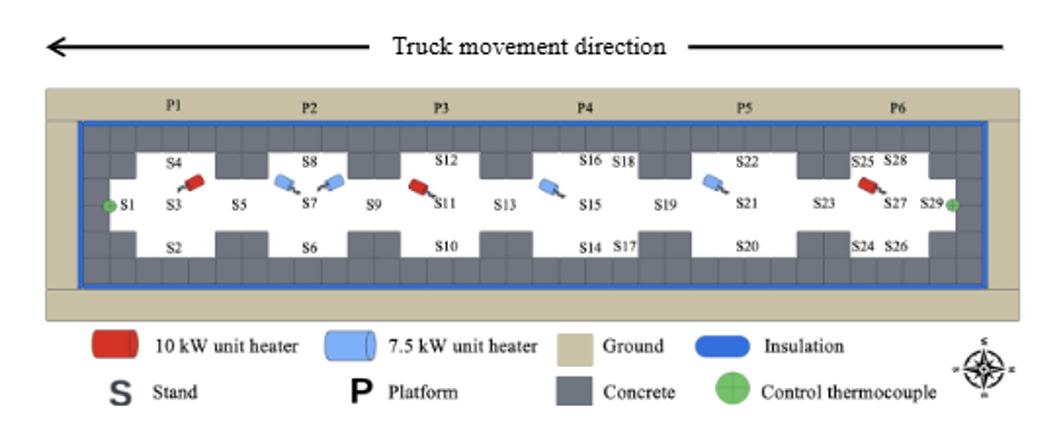

In [87]:
# Une fonction qui donne juste les portions de data qu'on veut
def gen_clean_df(
        data_selection:dict,
        df
        ):
    # Initialiser le nouveau df
    result = df.iloc[:, [0]].copy()

    for id, (heights, (start, end)) in data_selection.items():

        heights = heights.lower()

        for h in 'lmh':
            if h in heights:
                if h == 'l':
                    col_index = id + 2
                elif h == 'm':
                    col_index = id + 29 + 2
                elif h == 'h':
                    col_index = id + 2*29 + 2

                # Initialisée colonne à NaN
                col = pd.Series([np.nan]*len(df), index=df.index)
                # range spécifié
                col.iloc[start:end] = df.iloc[start:end, col_index]
                col.name = df.columns[col_index]
                # Ajouter au résultat
                result[col.name] = col

    return result

full_range = (0, len(df["Time"])) # Tuple (start_idx, end_idx)
default = ('lmh', full_range) # Low mid high et tout le data
# Le data qui est beau
clean_data = {
    # P1
    2 : default,
    3 : default,
    4 : default,
    # P2
    6 : default,
    7 : default,
    # P3
    10 : default,
    11 : default,
    # P4
    14 : ('lh', full_range),
    16 : ('lh', full_range),
    17 : ('lh', full_range),
    19 : ('lh', full_range),
    # P5
    21 : default,
    22 : ('lh', full_range),
    # P6
    23 : ('lmh', ( int(3/4 * len(df["Time"])), len(df["Time"]))),
    26 : ('lmh', (0, int(3/4 * len(df["Time"])) ) ),
    26 : ('lmh', (0, int(2/3 * len(df["Time"])) ) ),
}

clean_dataset = gen_clean_df(clean_data, df)
clean_dataset

,Time,T[degC]-Low-S2,T[degC]-Mid-S2,T[degC]-Top-S2,T[degC]-Low-S3,T[degC]-Mid-S3,T[degC]-Top-S3,T[degC]-Low-S4,T[degC]-Mid-S4,T[degC]-Top-S4,...,T[degC]-Mid-S21,T[degC]-Top-S21,T[degC]-Low-S22,T[degC]-Top-S22,T[degC]-Low-S23,T[degC]-Mid-S23,T[degC]-Top-S23,T[degC]-Low-S26,T[degC]-Mid-S26,T[degC]-Top-S26
0,2023-12-21 12:10,31.560910,37.913212,38.146814,34.793104,44.105918,46.526359,30.900530,34.026953,34.108362,...,11.794456,14.383413,3.949382,8.152400,NaN,NaN,NaN,-0.420443,-0.262928,0.135317
1,2023-12-21 12:12,31.345106,38.221547,38.455935,35.152043,44.318840,46.392710,30.010469,33.542966,33.984753,...,11.124312,13.676871,3.177693,8.008640,NaN,NaN,NaN,-0.614799,-0.420443,-0.057492
2,2023-12-21 12:14,30.096022,37.154014,37.691547,32.640345,42.838816,45.372148,28.717193,32.168026,32.825348,...,12.085692,14.843329,4.315216,8.229449,NaN,NaN,NaN,-0.142385,-0.081830,0.411335
3,2023-12-21 12:16,31.024726,37.593832,38.023328,33.257158,44.282249,46.358318,29.600942,33.592765,33.908886,...,14.180337,16.998668,6.082560,10.048923,NaN,NaN,NaN,1.777142,1.929844,2.549498
4,2023-12-21 12:18,32.214443,38.307302,38.579686,34.975090,44.203818,46.949953,31.081814,34.720304,34.826615,...,14.062347,16.572248,5.868690,9.798096,NaN,NaN,NaN,1.031838,1.043955,1.553302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54043,2024-03-05 13:36,17.126557,NaN,17.222470,16.732207,17.211813,17.190499,16.561648,16.412391,16.487022,...,15.527005,16.188466,14.522746,15.719105,15.313495,15.612391,16.849455,NaN,NaN,NaN
54044,2024-03-05 13:38,17.083928,NaN,17.211813,16.625610,17.286411,17.243784,16.657590,16.465699,16.604289,...,15.473636,16.188466,14.544136,15.697764,15.420261,15.612390,16.838796,NaN,NaN,NaN
54045,2024-03-05 13:40,17.083928,NaN,17.318380,16.657590,17.329037,17.275754,16.689569,16.529666,16.668250,...,15.484310,16.199130,14.544136,15.655078,15.377557,15.665750,16.806820,NaN,NaN,NaN
54046,2024-03-05 13:42,17.158528,NaN,17.329037,16.646930,17.350350,17.275754,16.614949,16.433715,16.646930,...,15.494985,16.167137,14.501356,15.697764,15.302818,15.644404,16.849453,NaN,NaN,NaN


# Curated Dataset
Les fonctions qui suivent utiliser les données qui sont belles et représentative 